# Описание проекта

Я — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.


Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv') 
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
                        
except:
    costs = pd.read_csv('C:/Users/belle/OneDrive/Документы/датасеты/Новая папка/costs_info_short.csv')
    visits = pd.read_csv('C:/Users/belle/OneDrive/Документы/датасеты/Новая папка/visits_info_short.csv')
    orders = pd.read_csv('C:/Users/belle/OneDrive/Документы/датасеты/Новая папка/orders_info_short.csv')


`visits` - лог сервера с информацией о посещениях сайта

`orders` - информация о заказах

`costs` - информация о расходах на рекламу

Проведем предобработку данных.

Рассмотрим `visits`

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
visits.duplicated().sum()

0

В `visits`:

- 309901 строк, 6 колонок
- нет пропущенных значений
- столбец user_id типа int 64, остальные object
- нет дубликатов

Что нужно переделать:
- изменить названия колонок
- изменить формат даты

In [6]:
visits.columns =['user_id', 'region', 'device', 'channel', 'session_start', 'session_end'] #поменяли названия колонок

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start']) #изменили тип данных
visits['session_end'] = pd.to_datetime(visits['session_end'])

Проверим столбец с датами на аномальные значения

In [8]:
print('Медиана начала сессии', visits['session_start'].median()) #ищем аномальные значения дат
print('Первая дата начала сессии' , visits['session_start'].min())
print('Последняя дата начала сессии', visits['session_start'].max())
print()
print('Медиана конца сессии', visits['session_end'].median())
print('Первая дата  конца сессии' , visits['session_end'].min())
print('Последняя дата конца сессии', visits['session_end'].max())

Медиана начала сессии 2019-08-10 10:56:43
Первая дата начала сессии 2019-05-01 00:00:41
Последняя дата начала сессии 2019-10-31 23:59:23

Медиана конца сессии 2019-08-10 11:19:41
Первая дата  конца сессии 2019-05-01 00:07:06
Последняя дата конца сессии 2019-11-01 01:38:46


In [9]:
visits.query('session_start > session_end') #проверим нет ли строк, в которых начало сессии раньше ее конца

,user_id,region,device,channel,session_start,session_end


Аномальных значений дат нет

Рассмотрим `orders`

In [10]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [12]:
orders.duplicated().sum()

0

В `orders`:

- 40212 строк, 3 колонки
- нет пропущенных значений
- столбцы user_id и revenue числовые, а event_dt имеет тип object
- нет дубликатов

Что нужно переделать:
- изменить названия колонок
- изменить формат даты

In [13]:
orders.columns =['user_id', 'event_dt', 'revenue'] #поменяли названия колонок

In [14]:
orders['event_dt'] = pd.to_datetime(orders['event_dt']).dt.date #изменили тип данных

In [15]:
orders['revenue'].unique()

array([ 4.99,  5.99,  9.99, 49.99, 19.99])

Аномальных значений в заказах нет

Рассмотрим `costs`

In [16]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [18]:
orders.duplicated().sum()

2

В `costs`:

- 1800 строк, 3 колонки
- нет пропущенных значений
- столбец costs типа float, a dt и channel имеют тип object
- нет дубликатов

Что нужно переделать:
- изменить названия колонок
- изменить формат даты

In [19]:
costs.columns=['dt', 'channel', 'costs'] #поменяли названия колонок

In [20]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date #поменяли тип данных

In [21]:
costs[costs['costs'] < 0] # проверяем на отрицательное значение стоимость рекламы

,dt,channel,costs


Аномальных значений в датафрейме нет

Напишем функции для дальнейшей работы

In [22]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [23]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [24]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [25]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [26]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [27]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [28]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [29]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

У нас 8 функций:
- `get_profiles` — для создания профилей пользователей,
- `get_retention` — для подсчёта Retention Rate,
- `get_conversion` — для подсчёта конверсии,
- `get_ltv` — для подсчёта LTV.

функции для построения графиков

- `filter_data` — для сглаживания данных,
- `plot_retention` — для построения графика Retention Rate,
- `plot_conversion` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Исследовательский анализ данных

Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователей

In [30]:
profiles = get_profiles(visits, orders, costs) # профили пользователей
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [31]:
costs['dt'] = pd.to_datetime(costs['dt']) #изменили тип данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [32]:
min_date = profiles['first_ts'].min() # нашли минимальную и максимальную дату привлечения пользователей
max_date = profiles['first_ts'].max()

In [33]:
print('минимальная дата', min_date)
print('максимальная дата', max_date)

минимальная дата 2019-05-01 00:00:41
максимальная дата 2019-10-27 23:59:04




Мы составили профили пользователей

Всего 150 008 уникальных пользователей

Минимальная дата привлечения пользователей - 1 мая 2019 года в 00:00:41

Максимальная дата привлечени пользователей - 27 октября 2019 года в 23:59:04

Проанализируем из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей

In [34]:
users_by_region = profiles.groupby('region').agg({'user_id':'nunique'}).sort_values(by='user_id' ,ascending=False)
users_by_region # таблица по странам и общему количеству пользователей

,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


In [35]:
paying_users_by_region = profiles.query('payer == True').groupby('region').agg({'user_id':'nunique'}).sort_values(by='user_id' ,ascending=False)
paying_users_by_region # таблица по странам и платящим пользователям

,user_id
region,
United States,6902
UK,700
France,663
Germany,616


In [36]:
users_by_region['share, %'] =  (paying_users_by_region['user_id']  / users_by_region['user_id']).transform(lambda x: "{:.1%}".format(x))
#процентное соотношение пользователей с платной версией ко всем пользователям из страны

In [37]:
users_by_region

,user_id,"share, %"
region,,
United States,100002,6.9%
UK,17575,4.0%
France,17450,3.8%
Germany,14981,4.1%


Приложениям пользуются пользователи из 5 стран (в скобочках указано количество пользователей):
- США (100 002)
- Великобритания (17 575)
- Франция (17 450)
- Германия (14 981)

Больше всего пользователей из США, так же в процентном соотношении больше всего платную подписку покупают пользователи из США.

Во Франции, Германии и Великобритании только около 4% пользователей покупают платную подписку

Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи


In [38]:
users_by_device = profiles.groupby('device').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
users_by_device # все пользователи в разбивке по девайсам

,user_id
device,
iPhone,54479
Android,35032
PC,30455
Mac,30042


In [39]:
paying_users_by_device = profiles.query('payer == True').groupby('device').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
paying_users_by_device #платящие пользователи в разбивке по девайсам

,user_id
device,
iPhone,3382
Android,2050
Mac,1912
PC,1537


In [40]:
users_by_device['share, %'] = (paying_users_by_device['user_id']  / users_by_device['user_id']).transform(lambda x: "{:.1%}".format(x))
users_by_device #процентное соотношение пользователей с платной версией ко всем пользователям по девайсам

,user_id,"share, %"
device,,
iPhone,54479,6.2%
Android,35032,5.9%
PC,30455,5.0%
Mac,30042,6.4%


Больше всего пользователей сидят с iPhone (54 479), c anroid 35 032. C PC и Mac сидят около 30 000 пользователей

В процентном соотношении больше всего ( около 6%) покупают пользователи, зашедшие с мака, айфона и андроида в первый раз.

Меньше всего у пк (5%)



Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.
Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.


In [41]:
users_by_channel = profiles.groupby('channel').agg({'user_id':'nunique'})
users_by_channel.sort_values(by='user_id', ascending = False)

,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


In [42]:
paying_users_by_channel = profiles.query('payer == True').groupby('channel').agg({'user_id':'nunique'})
paying_users_by_channel.sort_values(by='user_id', ascending = False) #все пользователи в разбивке по каналу привлечения

,user_id
channel,
FaceBoom,3557
TipTop,1878
organic,1160
WahooNetBanner,453
AdNonSense,440
RocketSuperAds,352
LeapBob,262
OppleCreativeMedia,233
lambdaMediaAds,225


In [43]:
users_by_channel['share'] =(paying_users_by_channel['user_id']  / users_by_channel['user_id']).transform(lambda x: "{:.1%}".format(x))
users_by_channel.sort_values(by='share', ascending = False) # плятящие пользователи в разбивке по каналу привлечения и их доля

,user_id,share
channel,,
TipTop,19561,9.6%
RocketSuperAds,4448,7.9%
WahooNetBanner,8553,5.3%
YRabbit,4312,3.8%
MediaTornado,4364,3.6%
LeapBob,8553,3.1%
OppleCreativeMedia,8605,2.7%
organic,56439,2.1%
FaceBoom,29144,12.2%


Больше всего людей находят приложения сами (~56 тысяч)

Два самых популярных канал привлечения, с которых чаще всего приходят люди:
- FaceBooM (~29 тысяч)
- TipTop (~20 тысяч)

Из вышеназванных трех каналов и пришло больше всего платящих пользователей (organic, FaceBooM и TipTop)

Около 8 тысячи клиентов пришли с OppleCreativeMedia, LeapBob, WahooNetBanner

Около 4 тысяч с RocketSuperAds, MediaTornadо, YRabbit и AdNonSense	

Всего 2 тысячи пользователей пришло с lambdaMediaAds	
    

Свыше 9% доля платящих составляет в следующих каналах:
- FaceBooM (12.2%)
- AdNonSense (11.3%)
- lambdaMediaAds (10.5%) интересно, что с этого канала пришло меньше всего людей, но с него высокая конверсия 
- TipTop (9.6%)

Меньшяя доля платящих пользователей пришла самостоятельно (всего 2% пользователей приобрели платную версию)

Как итог:

Рассматриваемый период - 2019 год, с 1 мая 00:00:41 до 27 октября 23:59:04

Всего 150008 уникальных пользователей

Приложением пользуются люди из 4 регионов (США, Великобритания, Франция и Германия), бОльшая часть пользователей из США (66%)

Чаще всего люди заходят с айфонов (36%), далее идет по убыванию андроид, пк и мак

Каналы продвижения приложения :
- TipTop	
- RocketSuperAds	
- WahooNetBanner	
- YRabbit
- MediaTornado
- LeapBob	
- OppleCreativeMedia
- FaceBoom	
- AdNonSense	
- lambdaMediaAds

Чаще всего пользователи приходят самостоятельно (38%).

Далее больше всего пользователлей приходят с FaceBoom (19%) и TipTop (13%)


Доля платящих клиентов больше всего у
- пользователей из США
- пользователей, зашедших с mac или iphone
- пользователей, которые пришли через FaceBoom,AdNonSense, lambdaMediaAds и TipTop


## Маркетинг

In [44]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Посчитаем общую сумму расходов на маркетинг

In [45]:
costs['costs'].sum()

105497.30000000002

Суммарно на маркетинг было затрачено 105 497 рублей

Выясним, как траты распределены по рекламным источникам

In [46]:
costs_by_source = costs.groupby('channel').agg({'costs': 'sum'}) #таблица с разбивкой затрат на каждый источник

#добавим столбец в процентном моотношении от общего числа затрат:
costs_by_source['sahre'] = (costs_by_source['costs'] / 105497.3).transform(lambda x : '{:.1%}'.format(x)) 

costs_by_source.sort_values(by = 'costs', ascending=False) #отсортируем по убыванию

,costs,sahre
channel,,
TipTop,54751.30,51.9%
FaceBoom,32445.60,30.8%
WahooNetBanner,5151.00,4.9%
AdNonSense,3911.25,3.7%
OppleCreativeMedia,2151.25,2.0%
RocketSuperAds,1833.00,1.7%
LeapBob,1797.60,1.7%
lambdaMediaAds,1557.60,1.5%
MediaTornado,954.48,0.9%


Половина всех затрат ушло на TipTop

Треть всех затрат на FaceBoom

Далее идет  WahooNetBanner (около 5%) и AdNonSense (около 4%)

Около 2% от затрат ушло на  OppleCreativeMedia, RocketSuperAds, LeapBob и lambdaMediaAds

И всего лишь 1% на MediaTornado и YRabbit

Построим визуализацию динамики изменения расходов во времени по каждому источнику

Сначала проанализируем по месяцам, потом по неделям и далее соеденим оба графика и сделаем общие выводы


In [47]:
costs['month']  = costs['dt'].dt.month # получим столбцы с номером месяца и недели
costs['week'] = costs['dt'].dt.isocalendar().week

Рассмотрим динамику цен по месяцам

In [48]:
pivtab_month = costs.pivot_table(index='channel', columns='month', values = 'costs', aggfunc='sum')
pivtab_month #cводная таблица по месяцам и каналам

month,5,6,7,8,9,10
channel,,,,,,
AdNonSense,1169.70,538.650,504.00,579.60,581.70,537.600
FaceBoom,3524.40,5501.100,5294.30,6274.40,6114.90,5736.500
LeapBob,140.28,314.580,313.53,369.81,343.98,315.420
MediaTornado,238.56,138.000,138.48,154.56,144.72,140.160
OppleCreativeMedia,169.75,370.000,366.50,439.25,427.75,378.000
RocketSuperAds,577.98,325.715,252.07,253.11,218.40,205.725
TipTop,2981.00,6675.600,8410.20,11202.00,13232.50,12250.000
WahooNetBanner,418.80,921.000,851.40,1040.40,977.40,942.000
YRabbit,299.70,106.200,97.38,124.74,152.79,163.410


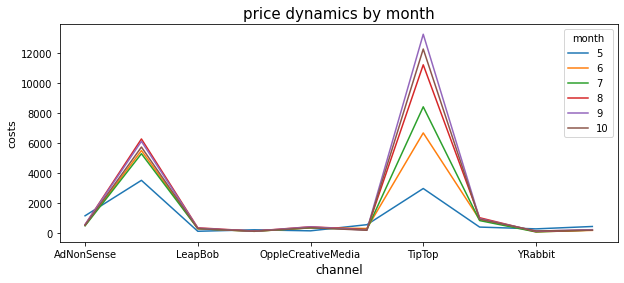

In [49]:
pivtab_month.plot(figsize=(10,4))
plt.xlabel('channel', fontsize = 12)
plt.ylabel('costs', fontsize = 11)
plt.title('price dynamics by month', fontsize = 15);

На таком графике плохо видна динамика изменения расходов во времени

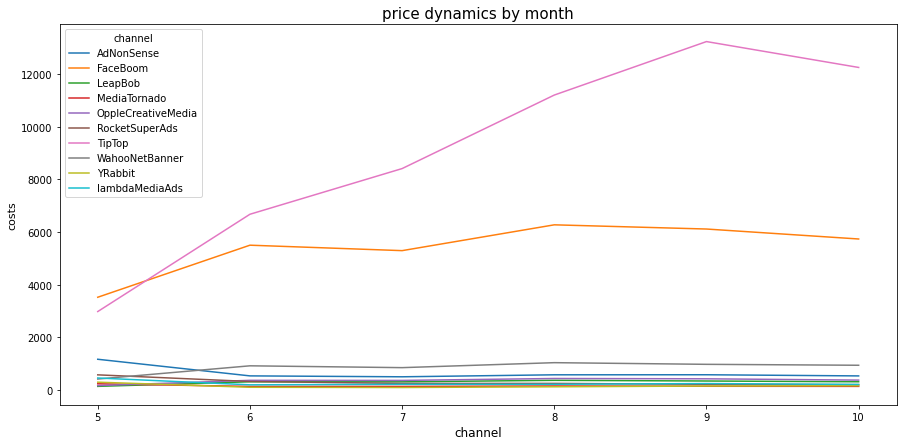

In [50]:
pivtab_month.T.plot(figsize=(15,7)); #перевернем таблицу
plt.xlabel('channel', fontsize = 12)
plt.ylabel('costs', fontsize = 11)
plt.title('price dynamics by month', fontsize = 15);

На графике видно, что больше всего затрат на TipTop и FaceBoom. Для обеих платформ рекламный бюджет в июне больше, чем в мае

Затраты на рекламу через TipTop постоянно росли, достигли своего пика в сентябре, после сентября рекламный бюджет немного урезали (на незначителную сумму)

Затраты на FaceBoom с июня по ноябрь варьировалсь от 5 до 6 тысяч

На остальных платформ не заметна сильная динамика изменений на этом графике



Посмотрим поближе динамику изменения цен, убрав из графика два самых популярных канала:

In [51]:
pivtab_month2 = costs.query('channel != "TipTop" and channel != "FaceBoom"').pivot_table(index='channel', columns='month', values = 'costs', aggfunc='sum')


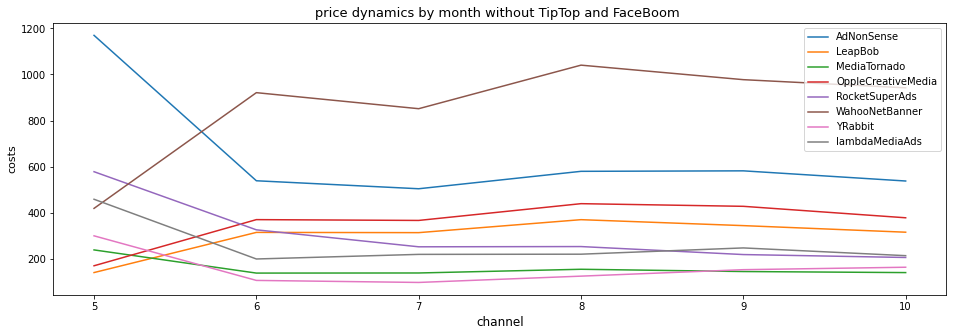

In [52]:
pivtab_month2.T.plot(figsize=(16,5))
plt.legend(loc='upper right');
plt.xlabel('channel', fontsize = 12)
plt.ylabel('costs', fontsize = 11)
plt.title('price dynamics by month without TipTop and FaceBoom ', fontsize = 13);

Динамика изменения цен видна только с мая по июнь. Бюджет повысился на WahooNetBanner, OppleCreativeMedia и LeapBob. Для остальных каналов его сократили.

Далее затрты были примерно в одном диапазоне
 

Рассмотрим изменения цен по неделям. Рассматриваемый период - с 18 по 41 неделю включительно

In [53]:
pivtab_week = costs.pivot_table(index='channel', columns='week', values = 'costs', aggfunc='sum')
pivtab_week #cводная таблица по месяцам и каналам

week,18,19,20,21,22,23,24,25,26,27,...,34,35,36,37,38,39,40,41,42,43
channel,,,,,,,,,,,,,,,,,,,,,
AdNonSense,211.05,273.00,265.65,266.70,202.650,102.90,96.60,141.75,148.05,130.200,...,142.80,133.35,100.800,100.80,139.650,192.15,155.40,136.500,118.650,154.35
FaceBoom,535.70,750.20,755.70,722.70,1208.900,1081.30,1042.80,1280.40,1647.80,1536.700,...,1411.30,1445.40,1151.700,1148.40,1496.000,1837.00,1761.10,1392.600,1291.400,1552.10
LeapBob,16.80,31.71,26.67,26.67,65.520,66.99,52.29,68.46,99.75,87.360,...,90.51,77.91,66.990,63.84,81.270,101.22,101.01,78.960,69.720,84.42
MediaTornado,38.64,61.68,59.04,50.16,36.960,27.60,29.76,32.16,40.56,43.440,...,35.28,33.84,30.240,25.92,30.240,48.24,42.00,36.960,29.040,37.44
OppleCreativeMedia,24.00,34.50,27.50,34.25,81.750,79.50,71.50,79.75,107.00,102.500,...,103.75,92.75,72.750,78.00,105.750,132.25,123.00,88.250,88.000,101.50
RocketSuperAds,99.45,139.23,138.06,131.04,97.695,76.05,63.18,80.73,78.26,75.075,...,40.30,51.35,40.625,40.95,56.225,63.70,66.30,51.675,46.475,50.70
TipTop,347.00,470.00,454.00,801.80,1421.200,1223.60,1121.00,1474.40,2343.60,2340.000,...,2514.00,2583.00,2563.000,2506.00,3241.000,3979.50,3703.00,3097.500,2737.000,3265.50
WahooNetBanner,49.20,92.40,90.00,79.20,179.400,196.80,166.20,201.60,285.00,256.800,...,244.80,235.80,174.600,192.60,226.200,303.00,309.00,208.800,216.000,253.20
YRabbit,52.20,75.90,69.30,65.40,49.800,25.80,17.46,22.14,27.90,28.260,...,30.03,24.36,27.930,29.76,39.600,47.52,45.36,38.310,36.450,48.33


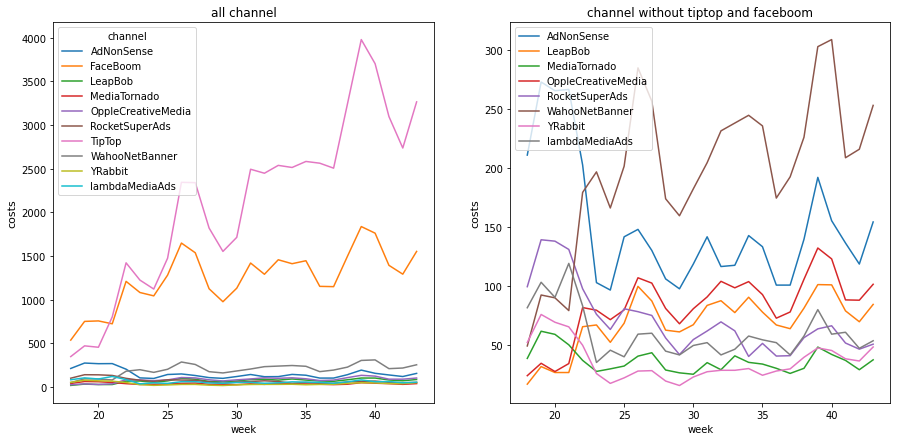

In [54]:
pivtab_week.T.plot(figsize=(18,7), 
                   ax = plt.subplot(1, 2, 1),
                  title = 'all channel',
                 )
plt.ylabel('costs', fontsize = 11)
pivtab_week.query('channel != "TipTop" and channel != "FaceBoom"').T.plot(figsize=(15,7), 
                                                                          ax = plt.subplot(1, 2, 2),
                                                                         title = 'channel without tiptop and faceboom')
plt.legend(loc='upper left')
plt.ylabel('costs', fontsize = 11)
plt.show() #построим график изменения цен по неделям


По графику видно, что линии сильно скачут, постоянно меняется бюджет рекламы из недели в неделю



Затраты на TipTop сильно варьируются от 480 до 4000 тысяч рублей. Тенденция - рост затрат

Видная общая тенденция - самые высокие затраты на рекламу на 26 и 39 неделях




Построим общий график по неделям и месяцам

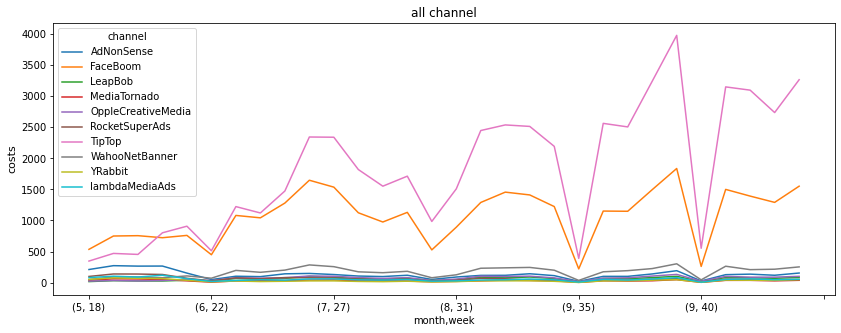

In [55]:

costs.pivot_table(index='channel', columns=['month', 'week'], values = 'costs', aggfunc='sum').T.plot(figsize=(14,5),
                                                                                                      title = 'all channel')

plt.ylabel('costs', fontsize = 11);


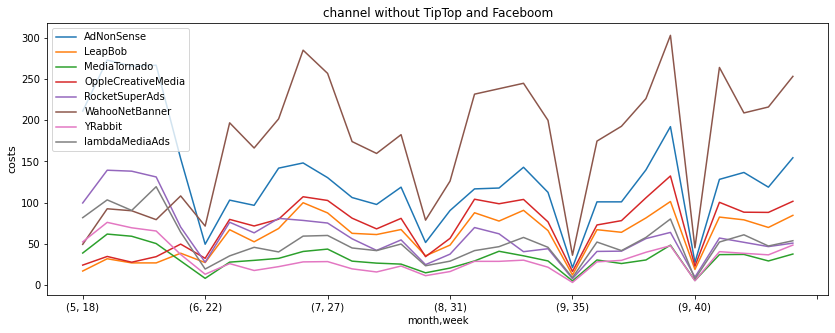

In [56]:
costs.query('channel != "TipTop" and channel != "FaceBoom"').pivot_table(index='channel', columns=['month', 'week'], values = 'costs', aggfunc='sum').T.plot(figsize=(14,5),
                                                                                                                    title = 'channel without TipTop and Faceboom')

plt.ylabel('costs', fontsize = 11)
plt.legend(loc='upper left');

По графику заметна тенденция - для всех каналов в одно и то же время одиноковые ( в соотношении) затраты. Например, на 22 неделе (в первой неделе июня) на все каналы было потрачено в несколько раз меньше денег на рекламу, чем на 26-27 неделю (конец июня и начало июля).

Узнаем сколько в среднем стоило привлечение одного пользователя из каждого источника


In [57]:
profiles = profiles.query('channel != "organic"') #уберем пользователей, которые пришли сами

In [58]:
table = costs.groupby('channel').agg({'costs' : 'sum'}) 
table#общие затраты по каналам

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


In [59]:
involvement = profiles.groupby('channel').agg({'user_id' : 'nunique'}) 
involvement #количество привлеченных пользователей с каждого канала

,user_id
channel,
AdNonSense,3880
FaceBoom,29144
LeapBob,8553
MediaTornado,4364
OppleCreativeMedia,8605
RocketSuperAds,4448
TipTop,19561
WahooNetBanner,8553
YRabbit,4312


In [60]:
involvement['costs'] = table['costs'] #добавим все в один даатафрейм
involvement

,user_id,costs
channel,,
AdNonSense,3880,3911.25
FaceBoom,29144,32445.60
LeapBob,8553,1797.60
MediaTornado,4364,954.48
OppleCreativeMedia,8605,2151.25
RocketSuperAds,4448,1833.00
TipTop,19561,54751.30
WahooNetBanner,8553,5151.00
YRabbit,4312,944.22


In [61]:
involvement['price_per_user'] = involvement['costs'] / involvement['user_id'] # посчитаем колько в среднем стоило привлечение одного пользователя
involvement 

,user_id,costs,price_per_user
channel,,,
AdNonSense,3880,3911.25,1.008054
FaceBoom,29144,32445.60,1.113286
LeapBob,8553,1797.60,0.210172
MediaTornado,4364,954.48,0.218717
OppleCreativeMedia,8605,2151.25,0.250000
RocketSuperAds,4448,1833.00,0.412095
TipTop,19561,54751.30,2.799003
WahooNetBanner,8553,5151.00,0.602245
YRabbit,4312,944.22,0.218975


In [62]:
print(involvement['price_per_user'].mean(), 'среднее')

0.7557348976115398 среднее


Самая высокая цена за клиента, пришедшего с TipTop - 2.8 рублей

Около 1 рубля стоит клиент, привлеченный с FaceBoom и AdNonSense

Самые дешевые клиенты обходятся с LeapBob, MediaTornado, YRabbit

Вывод 

Суммарно на маркетинг было затрачено 105 497 рублей

Половина всех затрат ушло на TipTop, а треть всех затрат на FaceBoom.

Если смотреть динамику изменения расходов во времени по месяцам, то можно заметить, что расходы по каналам практически не изменялись. Но стоит отметить одну тенденцию. В период с май по июнь для всех каналов изменились расходы. Для FaceBoom,  TipTop, WahooNetBanner, OppleCreativeMedia и LeapBob они повысились, для остальных канало понизились.

Если смотреть динамику изменения по неделям, то видно, что из неделю в неделю сильно меняются расходы на рекламу. Видная общая тенденция - самые высокие затраты на рекламу на 26 и 39 неделях.

В среднем привлечение одного клиента с TipTop очень дорого обходится – 2.8 рублей, для среднее – медиана 0,76


## Оценим окупаемость рекламы

В анализ не возьмем органических пользователей, так как на их привлечение не были потрачены деньги

In [64]:
observation_date = datetime(2019, 11, 1).date() # установим момент анализа данных
horizon_days = 14 # установим горизонт анализа данных

In [65]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
...,...,...,...,...,...,...,...,...,...
149999,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,2019-05-01,False,1.900000
150001,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.117838
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000


Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

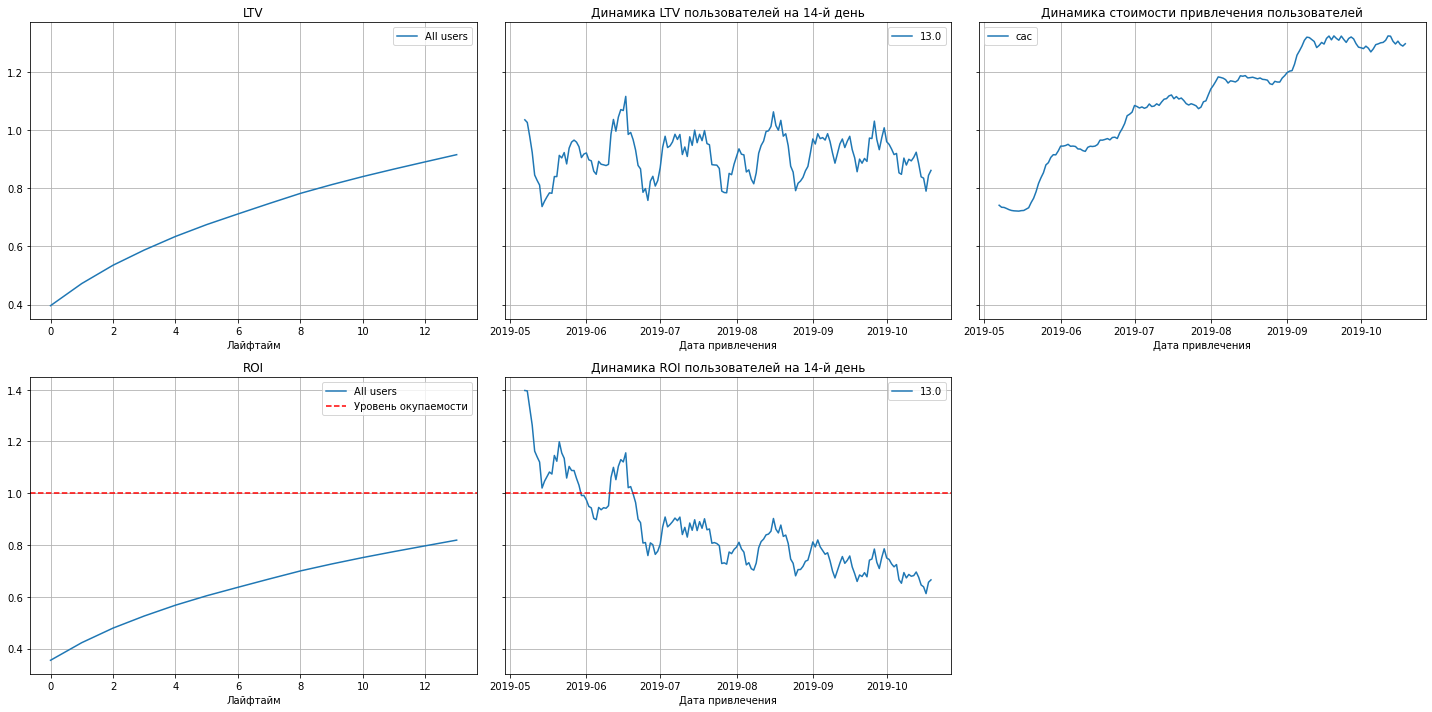

In [66]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 



Реклама не окупилась

На LTV влияет сезонный фактор, но он примерно одного уровня. Выше всего LTV у пользователей, привлеченных в июне.

А вот стоимость привлечения пользователей постоянно растет. 

Чем позже были привлечены пользователи - тем меньше показатель ROI, то есть окупаемость падает

Проверим конверсию пользователей и динамику её изменения

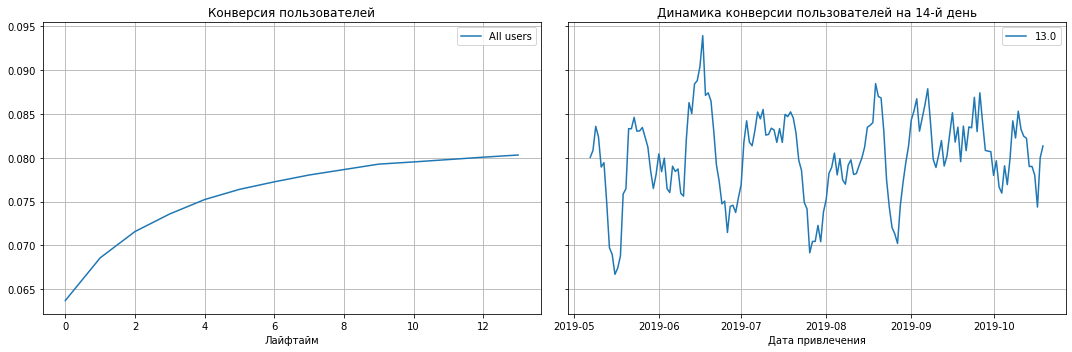

In [67]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days) 

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи хорошо конвертируются

Конверсия 14 дня меняется во времени. Пик для пользователей, привлеченных в середине июня, а спад был в середине мая, конце июня и конце августа.

То есть лучше всего конвертируются пользователи, которые привлчены были в середине июня. 

График динамики конверсии схож с графиком динамики LTV на 14 день.

Проверим удержание пользователей и динамику её изменения

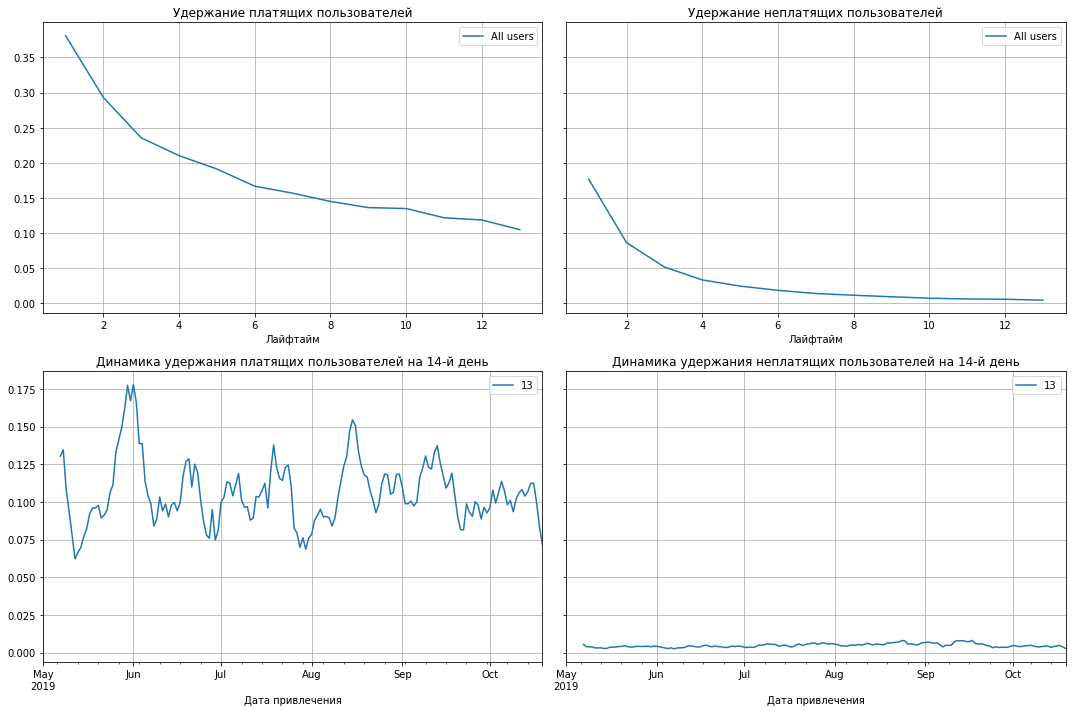

In [68]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей стабильно снижается, но это ожидаемо. 

Для платящих пользователей: 
- в 12 день осталось в 2,5 раза меньше пользователей, чем на 2 день
- если смотреть в динамике удержание на четырнадцатом дне, то она варьируется от сезона, в который пришел пользователь

Для неплатящих пользователей:
- изначально удержание меньше, чем у платящих пользователей
- если смотреть в динамике, то заметна стабильность - почти нулевое удержание





Проанализируем окупаемость рекламы с разбивкой по устройствам

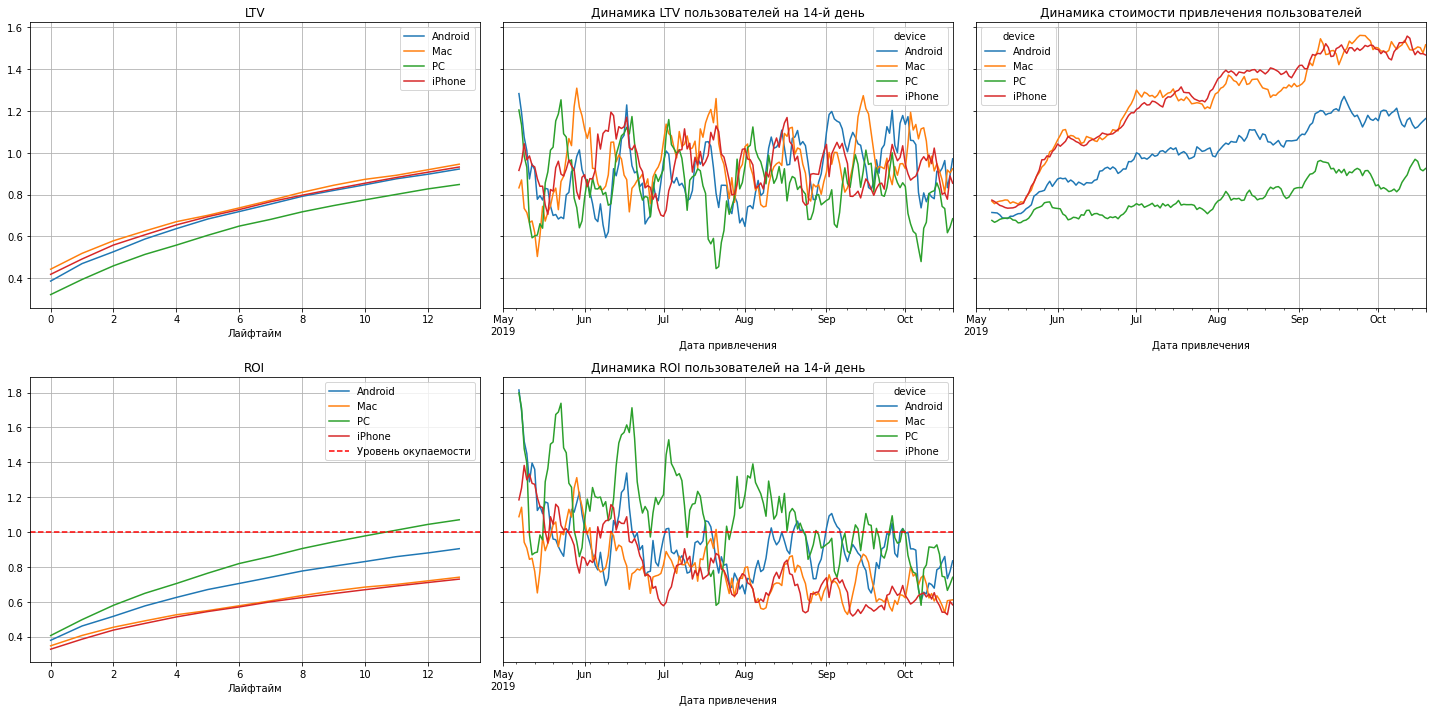

In [69]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions 
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


- LTV для всех устройств примерно одинаковый, но у ПК самый низкий
- Cтоимость привлечения для всех девайсов только росла, особенно сильный рост для мака и айфона
- Реклама окупилась только для ПК, у него же и заметен самый высокий ROI в динамике. 



Проанализируем окупаемость рекламы с разбивкой по странам

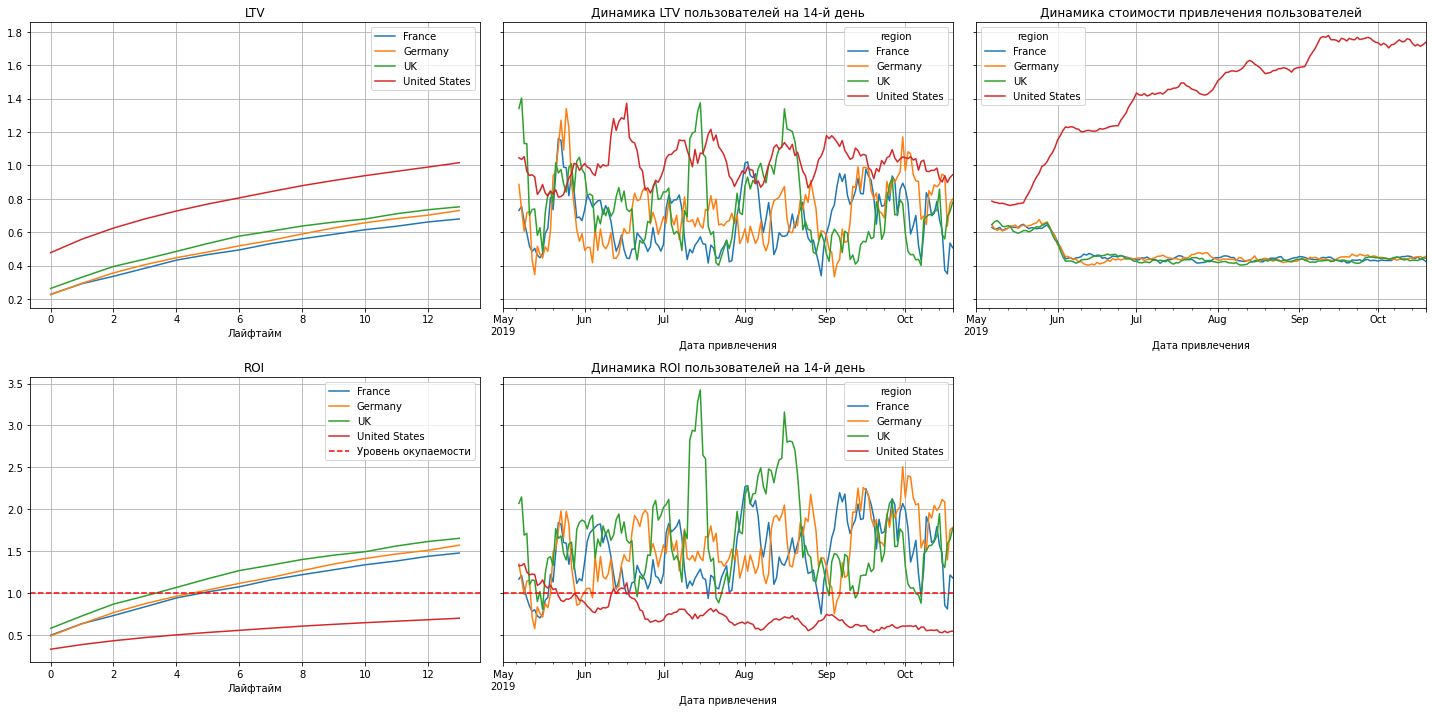

In [70]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions 
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Сразу видно, что показатели по пользователям из США сильно выбиваются из общей картины.

- LTV у пользователей США самый высокий
- Но только в США реклама не окупилась, в остальных регионах она окупилась уже на 2-3 день
- Также стоимость привлечения пользователей из США постоянно растет, а у других регионов стабильна (только упала в конце мая - начале июня)

То есть, хоть от пользователей из США поступает больше всего денег, все равно это не окупается тратами на рекламу.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

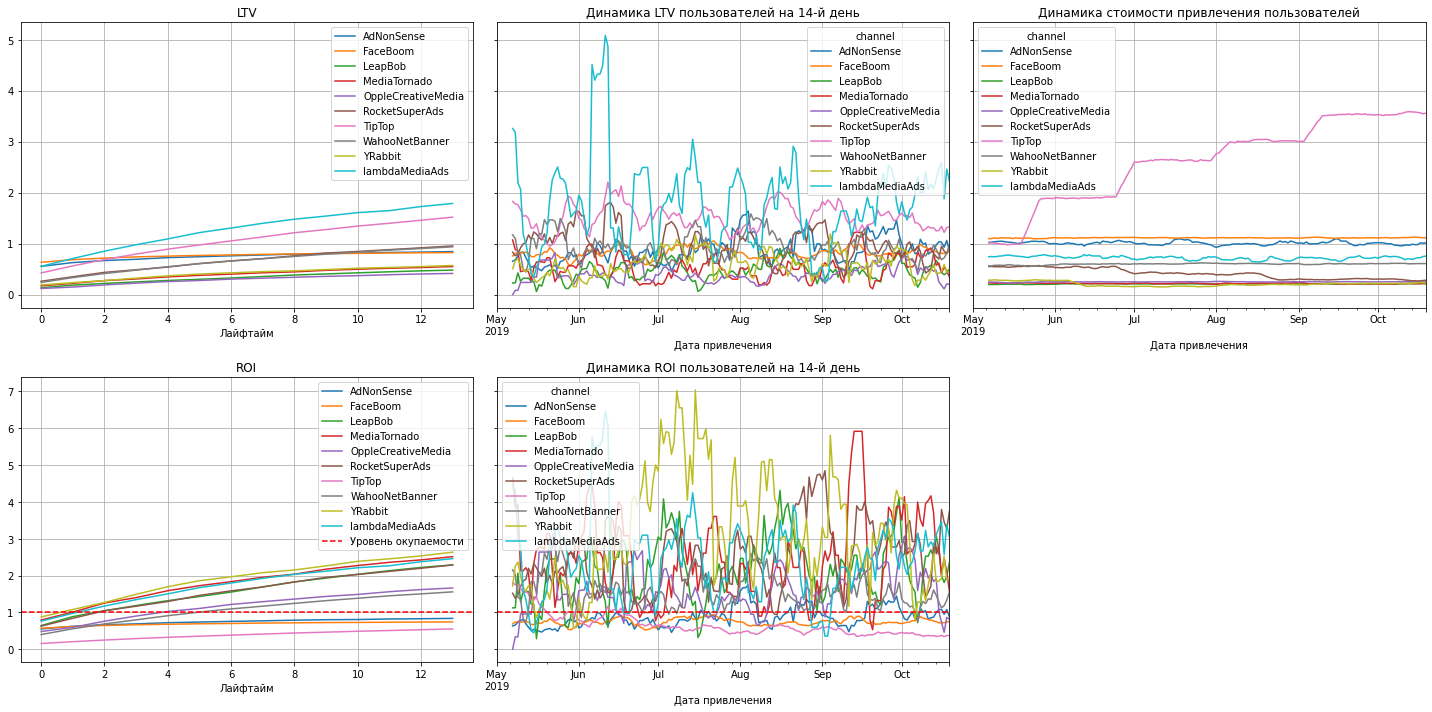

In [71]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions 
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- LTV выше всего для lambdaMediaAds и TipTop
- LTV и ROI зависит от сезона, но хорошо виден пик в июне
- Реклама не окупилась для AdNonSense, TipTop, FaceBoom. Для остальных каналов реклама окупилась на 2-4 дне, то есть довольно быстро



Построим конверсию по странам

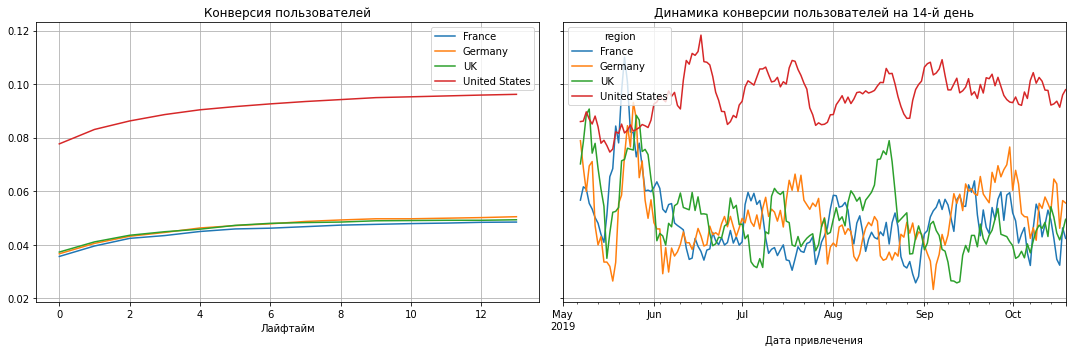

In [72]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']) 

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Построим графики удержания по странам

Лучше всего (в 2 раза) конверсия у пользователей из США, у остальных примерно одинаковая.

Выше всего конверсия у пользователей, первый раз зашедшие в конце мая

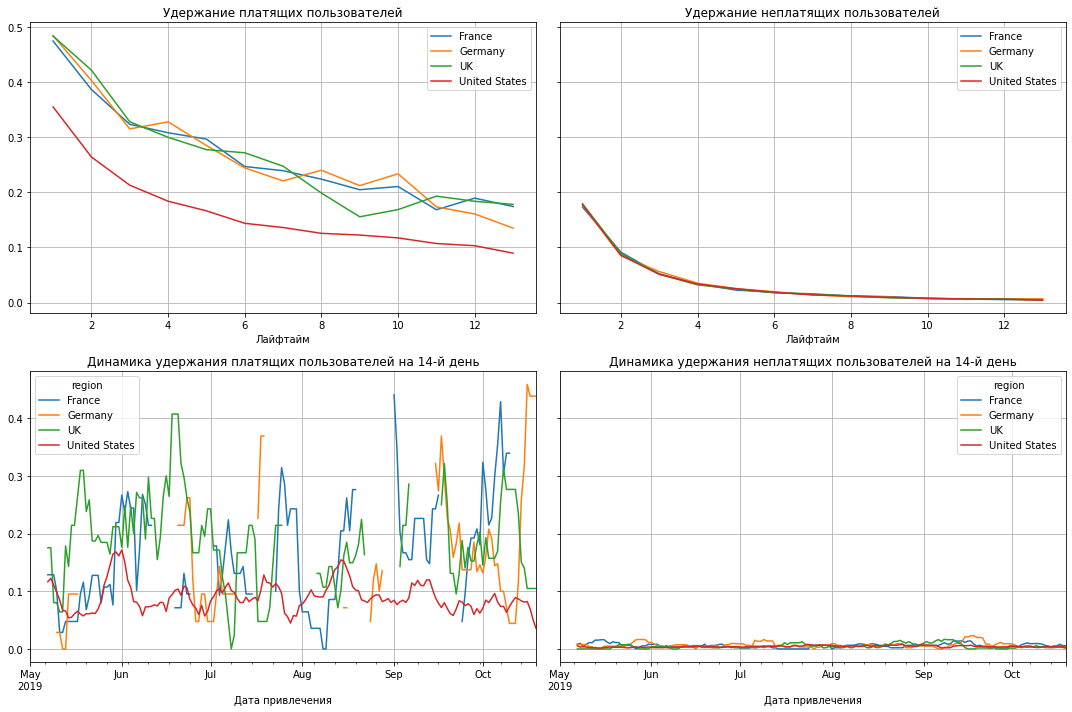

In [73]:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 


Для США самые плохие показатели удержания пользователей для платящих пользоваталей

Для неплатящих пользователй этот показатель идентичен 

Сезонность не сильно влияет на удержание пользователей

Ожидаемо, что для неплатящих пользователей удержание на второй день варьируется около 0

Построим конверсию по каналам привлечения

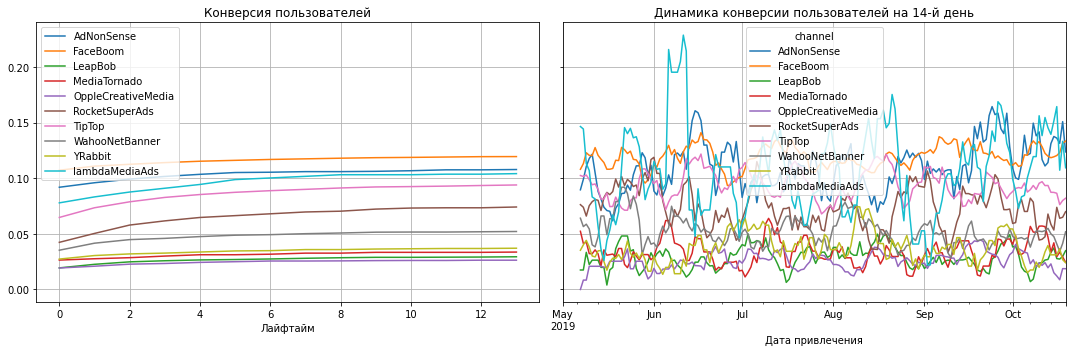

In [74]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']) 

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются пользователи из следующих каналов:
- FaceBoom
- AdNonSense
- lambdaMediaAds

Cредние показатели у 

- TipTop
- RocketSuperAds
- WahooNetBanner

У остальных каналов низкие показатели


В динамике самая высокая конверсия у пользователей, пришедших в начале июня с канала lambdaMediaAds

Постороим график удержания по каналам привлечения

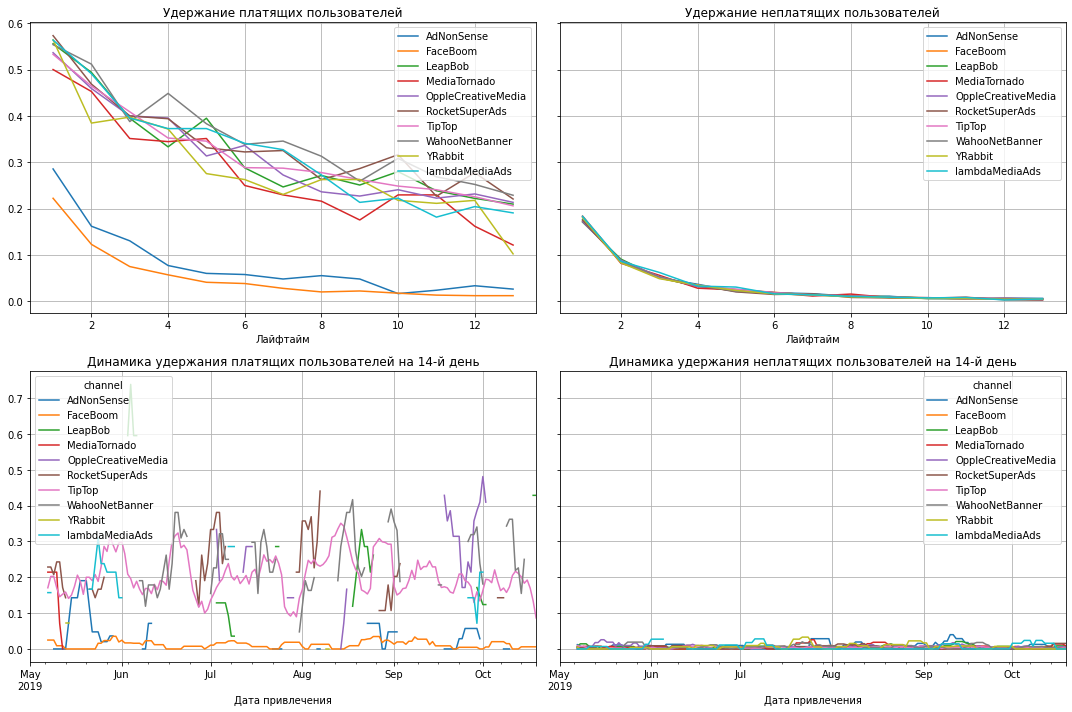

In [75]:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 


Сильно отличаются показатели удержания у каналов AdNonSense и FaceBoom (показатели ниже в 2 раза по сравнению с другими каналами)

Для неплатящих пользователй этот показатель идентичен для всех каналов

У канала FaceBoom cтабильно низкие показатели в динамике

Построим конверсию по устройствам

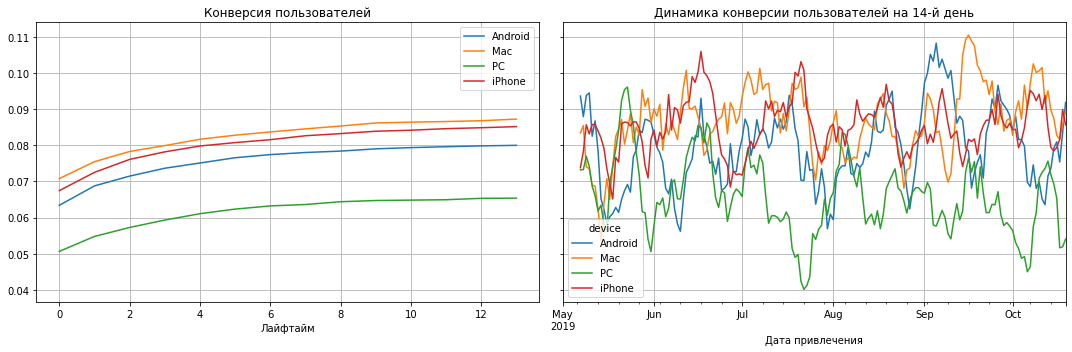

In [76]:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Самая высокая конверсия у мака и айфона, самая низкая у ПК

Построим график удержания по устройствам

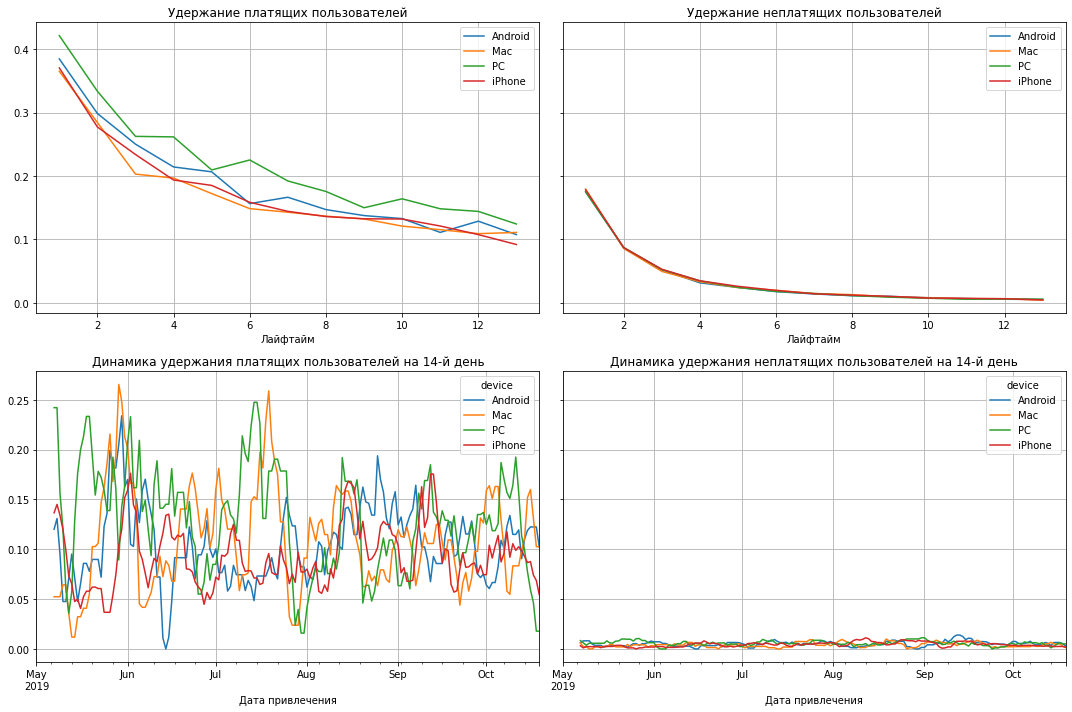

In [77]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание для каждого устройства примерно одинаковое

Сезонность практически не влияет на удержание пользователей

### Общий вывод

#### Данные
На выходе у нас было три файла:
- файл со всеми визитами потльзователей на сайт
- файл с перечнем заказов
- файл с информацией о рекламе через источники
В файлах не было дубликатов и пропущенных значений

#### Исследовательский анализ данных
Рассматриваемый период - 2019 год, с 1 мая 00:00:41 до 27 октября 23:59:04
Рассмотрено поведение 150008 пользователей

Больше всего пользователей из США, также приложением пользуются в Великобритании, Франции и Германии

Чаще всего в первый раз заходят через iPhone, конверсия покупки платной версии также выше, если пользователей использует устройство продукции Apple (мак или айфон)

Больше всего пользователей приходят сами, если говорить про переход с различных каналов, то лидируют FaceBoom и TipTop.  Но самая высокая доля платящих пользователей с FaceBooM, AdNonSense, lambdaMediaAds и TipTop

#### Маркетинг
Суммарно на маркетинг было потрачено 105 497 рублей. Из них 80% трат ушло на TipTop (50% от общей суммы) и FaceBoom (30% от общей суммы).
Выделим периоды, в которые было потрачено больше всего денег на рекламу:
- 22–23 неделя (начало июня)
- 29 неделя (середина июля)
- 36–37 неделя (начало сентября)
- 42 неделя (середина октября)
Больше всего денег было потрачено:
- 26 неделя (конец июня)
- 32–34 неделя (середина августа)
- 39 неделя (конец октября)

После анализа сколько в среднем стоило привлечение одного пользователя из каждого источника можно сделать следующие выводы:
- в среднем привлечение пользователя обходится в 0.76 рублей
- самая высокая цена за пользователя с канала – 2,7 рубля. Около 1 рубля стоит клиент, привлеченный с FaceBoom и AdNonSense. Самые дешевые клиенты обходятся с LeapBob, MediaTornado, YRabbit (0,2 рубля)

#### Окупаемость рекламы
1. По региону:

У США самая высокая конверсия пользователей, но самое низкое удержание. Также для США самый высокий LTV (в 1,3 раза больше), но затраты выше других каналов в 4 раза.

Следовательно, для США реклама не окупилась.

Рынок Европы в этом плане стабильнее и окупает себя.


2. По каналам привлечения:

Идельный пример - канал  lambdaMediaAds.

Средние показатели по удержанию пользователей, но одна из самых высоких конверсий. Плюс высокий показатель LTV и низкая стоимость привлечения, а знаичит канал окупается.

Каналы, которые не окупились:
- FaceBoom и AdNonSense (почти в 4 раза меньше показатели по удержанию платящих пользователей)
- TipTop - средние показатели, но необъяснимый рост затрат на рекламу (местами в 3,5 раза больше, чем для других каналов)

3. По устройствам:

Окупился только ПК. Хоть конверсия и LTV чуть ниже по сравнению с другими девайсами, но затраты на рекламу меньше примерно в 1,5 раза по сравнению с утройствами от apple. 

Показатели мака и айфона идентичны. Причина - высокие затраты на рекламу, а ltv примерно на том же уровне, что и другие девайсы. Стоит учесть, что айофны очень популярны в США и такие показатели связаны с низкими показателями пользователей из США

Андроид по всем показателям ничем не выделяется, но цены на рекламу выше, чем для пк, поэтому он не окупился.






Общие идеи, которые стоит расссмотреть подробнее:
    
1. Перейти на европейский рынок, так как показатели для него хорошие
2. Пересмотреть распределение бюджета на каналы привлечения (На TipTop тратится половина рекламного бюджета, но показатели у него плохие). Как пример, обратить внимание на lambdaMediaAds)
3. Пересмотреть в целом бюджет, так как в большинстве случаев он необоснованно высокий